# Deepfashion TryOn

In [1]:
!git clone https://github.com/switchablenorms/DeepFashion_Try_On #using a pretrained model to inference on our dataset
%cd DeepFashion_Try_On

Cloning into 'DeepFashion_Try_On'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 384 (delta 119), reused 147 (delta 80), pack-reused 191
Receiving objects: 100% (384/384), 14.75 MiB | 50.52 MiB/s, done.
Resolving deltas: 100% (186/186), done.
/kaggle/working/DeepFashion_Try_On


## Download test data

In [2]:
%cd ACGPN_inference
!mkdir -p ../Data_preprocessing
!cp -rf /kaggle/input/viton-dataset/ACGPN_TestData/* ../Data_preprocessing
!ls ../Data_preprocessing

/kaggle/working/DeepFashion_Try_On/ACGPN_inference
readme.txt  test_colormask  test_img	test_mask
test_color  test_edge	    test_label	test_pose


## Loading the pretrained model

In [3]:
# copy a pre-trained model (checkpoint)
!cp -rf /kaggle/input/acgpn-checkpoints/label2city checkpoints

## Test Model

In [4]:
!python test.py

?
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
data_type: 32
dataroot: ../Data_preprocessing/
debug: False
display_freq: 100
display_winsize: 512
fineSize: 512
gpu_ids: [0]
input_nc: 3
isTrain: True
label_nc: 20
lambda_feat: 10.0
loadSize: 512
load_pretrain: ./checkpoints/label2city
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: test
pool_size: 0
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 10
save_latest_freq: 1000
serial_batches: False
tf_log: False
use_dropout: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [Al

### Output

In [5]:
!ls sample | head -5

000001_0.jpg
000010_0.jpg
000020_0.jpg
000028_0.jpg
000038_0.jpg
ls: write error: Broken pipe


## Display sample images

In [22]:
from IPython.display import Image

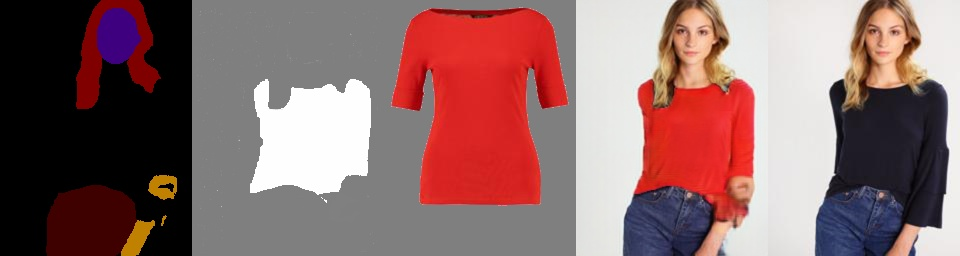

In [25]:
Image('sample/000010_0.jpg')

## FID Score and Dice Score: Evaluating Generated Image Quality
### Introduction
The FID (Frechet Inception Distance) score and Dice score are both metrics used to evaluate the quality of generated images, but they serve different purposes.

### FID Score
#### Purpose
The FID score measures the similarity between two distributions of images (e.g., real and generated images). A lower FID score indicates that the generated images are more similar to the real images.

#### Calculation
To calculate the FID score, you need to:
1. **Extract features**: Extract features from the real and generated images using a pre-trained CNN (e.g., Inception-V3).
2. **Calculate mean and covariance**: Calculate the mean and covariance of the features for both distributions.
3. **Compute FID score**: Compute the FID score using the following formula:

FID = ||μ1 - μ2||^2 + Tr(Σ1 + Σ2 - 2(Σ1 Σ2)^1/2)
where μ1 and μ2 are the mean features, Σ1 and Σ2 are the covariance matrices, and Tr() is the trace operator.

### Dice Score
#### Purpose
The Dice score (also known as the Sørensen–Dice coefficient) measures the similarity between two images in terms of their semantic content. It's commonly used to evaluate the performance of image segmentation models.

#### Calculation
To calculate the Dice score, you need to:
1. **Segment images**: Segment the images into regions of interest (e.g., objects, classes).
2. **Calculate intersection and union**: Calculate the intersection and union of the segmented regions.
3. **Compute Dice score**: Compute the Dice score using the following formula:

Dice = 2 * (intersection) / (union + intersection)

A higher Dice score indicates better segmentation performance.

In [19]:
from PIL import Image
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.metrics import adapted_rand_error

def extract_features(image_array):
	model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
	processed_image = preprocess_input(image_array)
	features = model.predict(processed_image)
	return features

def calculate_fid(generated_array, real_array):
	generated_features = extract_features(generated_array)
	real_features = extract_features(real_array)
	
	mu1, sigma1 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
	mu2, sigma2 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
	
	(fid_score,) = calculate_fid_score(mu1, mu2, sigma1, sigma2)
	return fid_score

def calculate_fid_score(mu1, mu2, sigma1, sigma2, eps=1e-6):
	diff = mu1 - mu2
	
	covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
	if not np.isfinite(covmean).all():
		msg = ('fid calculation produces singular product; '
		       'adding %s to diagonal of cov estimates') % eps
		print(msg)
		offset = np.eye(sigma1.shape[0]) * eps
		covmean = sqrtm((sigma1 + offset).dot(sigma2 + offset))
	
	tr_covmean = np.trace(covmean)
	return ((diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean) / real_array.shape[0])

def calculate_dice(generated_array, real_array):
	generated_segmentation = slic(generated_array)
	real_segmentation = slic(real_array)
	
	dice_score = calculate_dice_score(generated_segmentation, real_segmentation)
	return dice_score

def calculate_dice_score(segmentation1, segmentation2):
	return 1 - adapted_rand_error(segmentation1, segmentation2)

# Load images
generated_img = Image.open('sample/000010_0.jpg')
real_img = Image.open('/kaggle/input/viton-dataset/ACGPN_TestData/test_img/000010_0.jpg')

# Convert images to numpy arrays
generated_array = np.array(generated_img)
real_array = np.array(real_img)

# Add batch dimension
generated_array = np.expand_dims(generated_array, axis=0)
real_array = np.expand_dims(real_array, axis=0)


# Calculate FID score
fid_score = calculate_fid(generated_array, real_array)
print("FID Score:", fid_score)

# Calculate Dice score
dice_score = calculate_dice(generated_array, real_array)
print("Dice Score:", dice_score)

ValueError: m has more than 2 dimensions